# Image Filtering and Segmentation

Let's now cover the basics of image filtering and segmentation using pyclesperanto.

In [1]:
import pyclesperanto_prototype as cle
import numpy as np
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
cle.select_device('TX')  # TODO: change to your GPU

<NVIDIA GeForce RTX 3090 on Platform: NVIDIA CUDA (1 refs)>

## Nuclei detection and segmentation
We used image set BBBC022v1 [Gustafsdottir et al., PLOS ONE, 2013], available from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012].

And image set frame_imgs_30fps [Greg Stevens] from https://groups.oist.jp/bptu/honeybee-tracking-dataset



## Try segmenting both Nuclei and Bees

The Nuclei are well separated, have a high SNR, and do not contain complicated textures, so you should be able to produce nice segmentation results with a classical image processing pipeline.  The bee image is more difficult, perhaps with some tuning and creative thinking you can get a nice result?  Give it a try. 

In [12]:
#image = imread("../../data/IXMtest_A02_s9.tif")[:,:,0]
image = imread("../../data/bees2.tif")

# define an interesting sub-region
bb_x=200
bb_y=0
bb_width=200
bb_height=200

Let's first have a look at our data and the region of interest we have defined

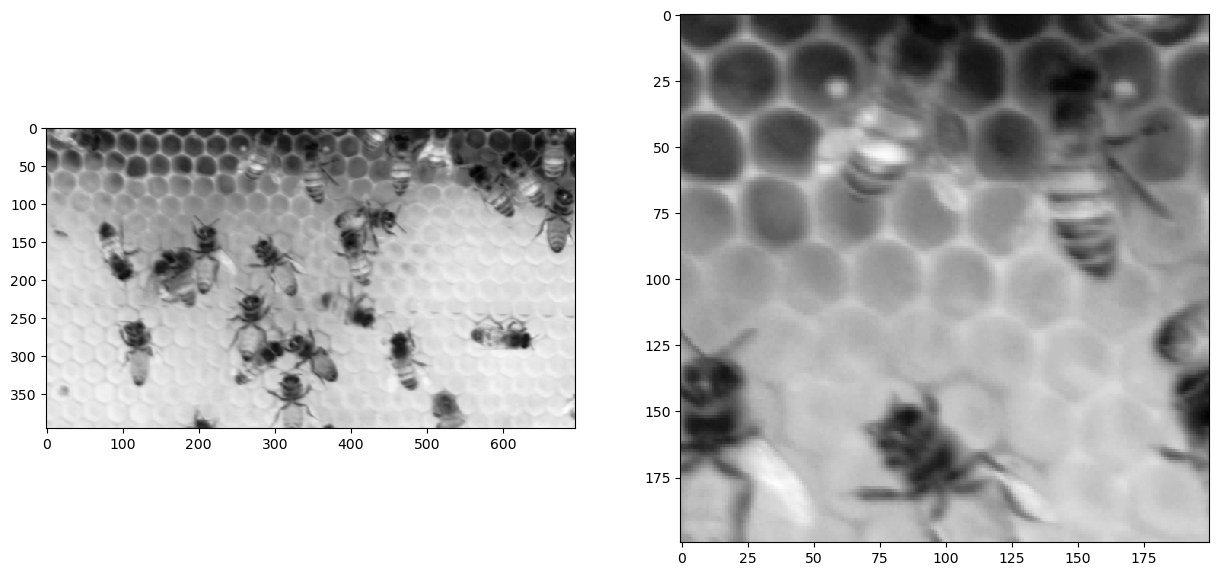

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
cle.imshow(image, plot=axs[0])
cle.imshow(cle.crop(image, start_x=bb_x, start_y=bb_y, width=bb_width, height=bb_height), plot=axs[1])

We can apply a first segmentation using the following workflow:
- blur the image in order to reduce noise and high frequency structures
- apply a thresholding method to create a binary from the image, our object are marked by fluorescence, hence high intensity should correspond to what we are looking for
- label the binary image to assign a unique ID to each object and be able to identify them

This is a very simple segmentation approach which, in well prepared and controlled experiments, can be sufficient to segment objects of interest.

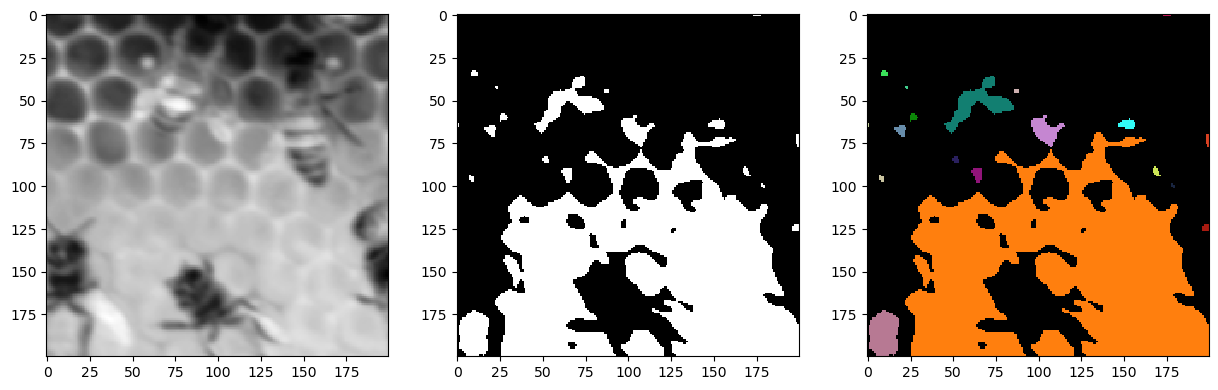

In [14]:
blurred = cle.gaussian_blur(image, sigma_x=1, sigma_y=1)
binary = cle.threshold_otsu(blurred)
labels = cle.connected_components_labeling_box(binary)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
cle.imshow(cle.crop(blurred, start_x=bb_x, start_y=bb_y, width=bb_width, height=bb_height), plot=axs[0])
cle.imshow(cle.crop(binary, start_x=bb_x, start_y=bb_y, width=bb_width, height=bb_height), plot=axs[1])
cle.imshow(cle.crop(labels, start_x=bb_x, start_y=bb_y, width=bb_width, height=bb_height), labels=True, plot=axs[2])

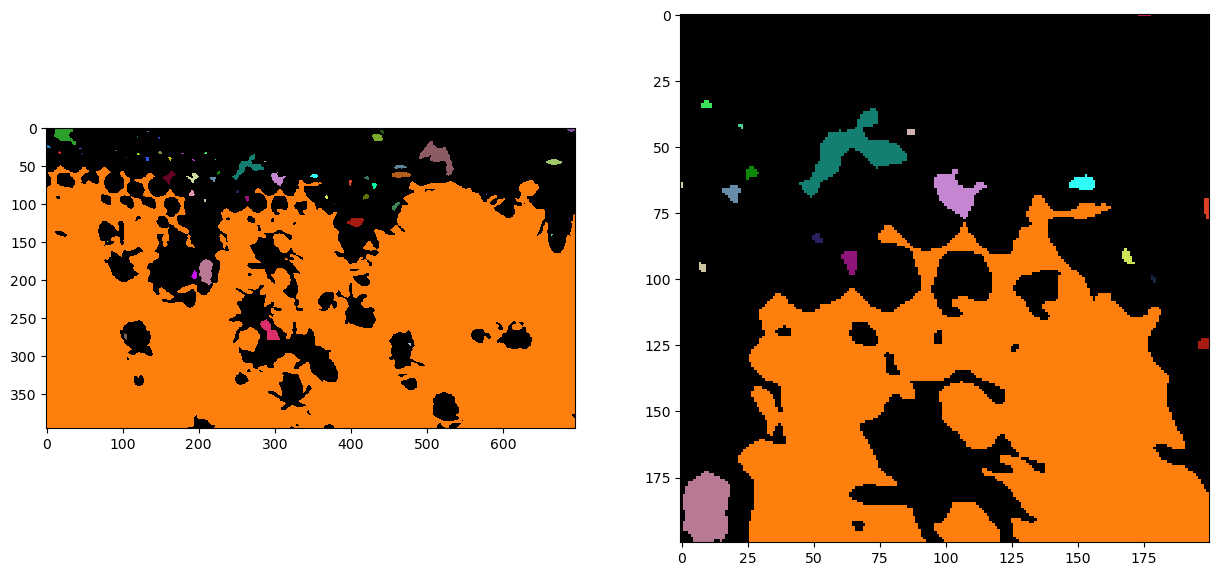

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
cle.imshow(labels, labels=True, plot=axs[0])
cle.imshow(cle.crop(labels, start_x=bb_x, start_y=bb_y, width=bb_width, height=bb_height), labels=True, plot=axs[1])

And let's have a look globally ...

Not bad (of course) but we can hoppefully do better as we have touching objects. Let's try to separate them by improving a bit our approach.

We keep our `blurred` and `binary` images on the side, and we now try to detect our objects by concentrating their signal into spots and finding intensity maxima in the image.
We can then reuse the `binary` image of our objects to make sure we only keep detection of actuals objects and not random maxima in the background. 

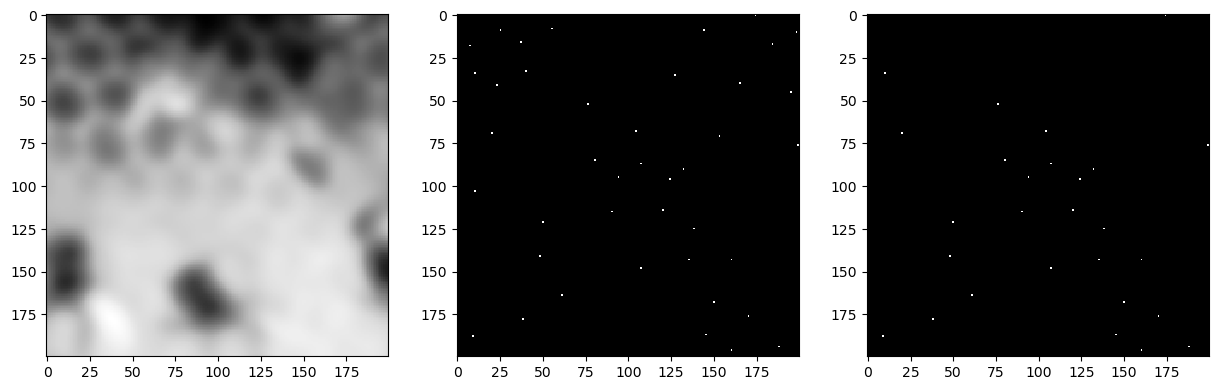

In [16]:
temp = cle.gaussian_blur(image, sigma_x=5, sigma_y=5, sigma_z=5)
maxima_spots = cle.detect_maxima_box(temp)
seeds = cle.binary_and(binary, maxima_spots)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
cle.imshow(cle.crop(temp, start_x=bb_x, start_y=bb_y, width=bb_width, height=bb_height), plot=axs[0])
cle.imshow(cle.crop(maxima_spots, start_x=bb_x, start_y=bb_y, width=bb_width, height=bb_height), plot=axs[1])
cle.imshow(cle.crop(seeds, start_x=bb_x, start_y=bb_y, width=bb_width, height=bb_height), plot=axs[2])

We can now use the detected spots as seed initialisation to a voronoi algorithm which partitions the image space per distance.  
reusing again our binary image from above, we can carve out the cells from the voronoi tesselation using binary operations and optain a properply segmented image.

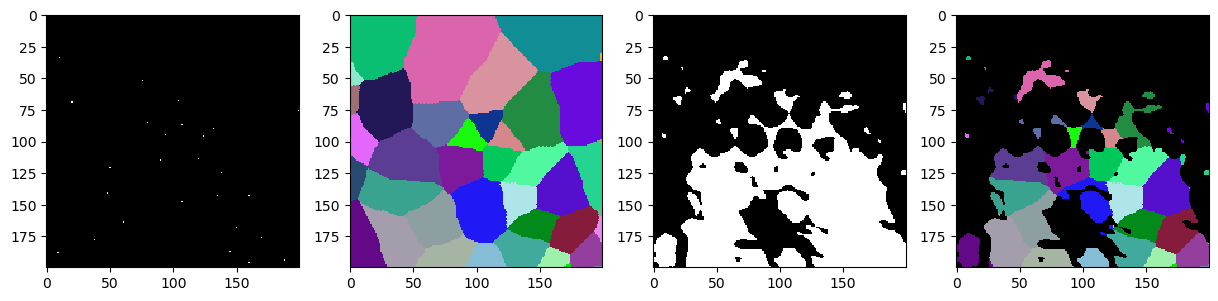

In [17]:
voronoided = cle.voronoi_labeling(seeds)
segmented = voronoided * binary

fig, axs = plt.subplots(1, 4, figsize=(15, 15))
cle.imshow(cle.crop(seeds, start_x=bb_x, start_y=bb_y, width=bb_width, height=bb_height), plot=axs[0])
cle.imshow(cle.crop(voronoided, start_x=bb_x, start_y=bb_y, width=bb_width, height=bb_height), labels=True, plot=axs[1])
cle.imshow(cle.crop(binary, start_x=bb_x, start_y=bb_y, width=bb_width, height=bb_height), plot=axs[2])
cle.imshow(cle.crop(segmented, start_x=bb_x, start_y=bb_y, width=bb_width, height=bb_height), labels=True, plot=axs[3])

Of course, as this is a very usefull pipeline to use and reuse, you can find it as a all in one operation call `voronoi_otsu_labeling` in the `cle` package. The only two parameters required from the users is the the first sigma value for computing the gausian blur and binary threshold, and the second sigma value for detecting local intensity maxima. The rest of the operations are parameter free.

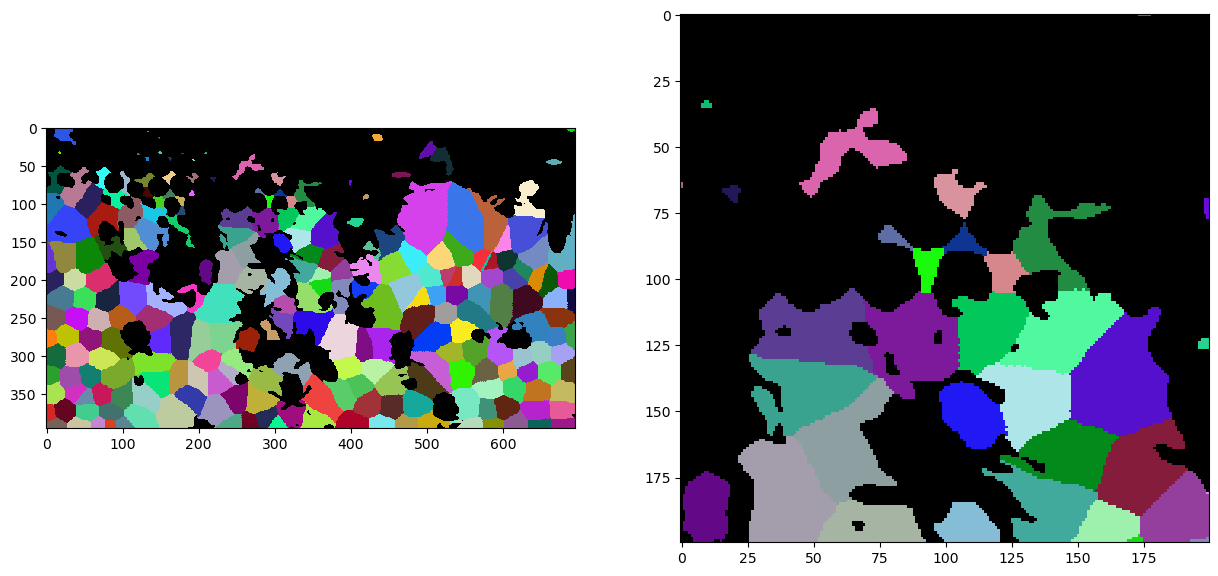

In [18]:
segmentation = cle.voronoi_otsu_labeling(image, spot_sigma=5, outline_sigma=1)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
cle.imshow(segmentation, labels=True, plot=axs[0])
cle.imshow(cle.crop(segmentation, start_x=bb_x, start_y=bb_y, width=bb_width, height=bb_height), labels=True, plot=axs[1])

In [11]:
import napari
viewer = napari.Viewer()
viewer.add_image(image)
viewer.add_labels(segmentation)


napari.manifest -> 'napari-hello' could not be imported: Cannot find module 'napari_plugins' declared in entrypoint: 'napari_plugins:napari.yaml'


<Labels layer 'segmentation' at 0x1ef56f77040>